In [1]:
# ! pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [12]:
# ! pip install --upgrade tensorflow-probability tensorflow

In [13]:
import tensorflow_probability.substrates.jax as tfp

In [40]:
import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from flax.training import train_state

import optax
import tensorflow as tf
# import numpyro
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [81]:
train_data = np.load("train_data.npy")

In [82]:
class Encoder(nn.Module):
    dim_hidden: int = 64
    dim_latents: int = 32

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.dim_hidden, kernel_size=(3, 3), strides=2)(x)  # Output: 80x80
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)  # Output: 40x40
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)  # Output: 20x20
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)  # Output: 10x10
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
        mean_x = nn.Dense(self.dim_latents)(x)
        logvar_x = nn.Dense(self.dim_latents)(x)
        return mean_x, logvar_x


class Decoder(nn.Module):
    dim_hidden: int = 64

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10 * 10 * self.dim_hidden)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], 10, 10, -1)
        x = nn.ConvTranspose(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)  # Output: 20x20
        x = nn.relu(x)
        x = nn.ConvTranspose(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)  # Output: 40x40
        x = nn.relu(x)
        x = nn.ConvTranspose(features=self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)  # Output: 80x80
        x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))(x)  # Output: 160x160
        return x

In [83]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 20

    def setup(self):
        self.encoder = Encoder(dim_latents=self.num_latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):

        # Get variational parameters from encoder
        mu, logvar = self.encoder(x)

        # Sample from variational distrib. of latents
        # z = numpyro.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar))).rsample(key=z_rng)
        z = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar))).sample(seed=z_rng)

        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

    def generate(self, z):
        return self.decoder(z)

@jax.vmap
def kl_divergence(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior
    """
    prior_latent = tfp.distributions.Normal(loc=0, scale=1)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar)))  # Variational latent distrib.
    
    return tfp.distributions.kl_divergence(q_latent, prior_latent).sum()

@jax.vmap
def mse_loss(pred, true):
    return jnp.mean((pred - true) ** 2)

def compute_metrics(recon_x, x, mu, logvar):
    mse_loss_val = mse_loss(recon_x, x).mean()
    kld_loss = kl_divergence(mu, logvar).mean()
    return {
      'recon_loss': mse_loss_val,
      'kl_div': kld_loss,
      'loss': mse_loss_val + kld_loss
    }

def model_vae():
    return VAE(num_latents=num_latents)

In [84]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = model_vae().apply({'params': params}, batch, z_rng)

        reco_loss = mse_loss(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = reco_loss + kld_loss
        return loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

In [85]:
batch_size = 16
num_latents= 64
rng = jax.random.PRNGKey(42)
learning_rate = 3e-4
train_steps = 10000

rng, key = random.split(rng)

init_data = jnp.ones((batch_size, 160, 160, 1), jnp.float32)

state = train_state.TrainState.create(
    apply_fn=model_vae().apply,
    params=model_vae().init(key, init_data, rng)['params'],
    tx=optax.adamw(learning_rate, weight_decay=1e-5),
)

In [86]:
@jax.jit
def eval(params, z):
    def eval_model(vae):
        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 160, 160, 1)
        return generate_images

    return nn.apply(eval_model, model_vae())({'params': params})

In [99]:
rng, z_key, eval_rng = random.split(rng, 3)

for t in tqdm(range(train_steps)):
    idx = jax.random.choice(rng, train_data.shape[0], shape=(batch_size,))
    batch = jnp.array(train_data[idx])
    rng, key = random.split(rng)
    state = train_step(state, batch, key)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [191]:
rng = jax.random.PRNGKey(12)
rng, z_key, eval_rng = random.split(rng, 3)
z = jax.random.normal(z_key, (16, num_latents))

In [209]:
n_samples = 32

In [223]:
z1 = jax.random.normal(z_key, (1, num_latents))
rng, z_key, eval_rng = random.split(rng, 3)
z2 = jax.random.normal(z_key, (1, num_latents))

def interpolate(v1, v2, alpha):
    return (1 - alpha) * v1 + alpha * v2

# z = np.array([interpolate(z1, z2, alpha) for alpha in np.linspace(0., 1., 16)])
z = np.array([alpha * jnp.ones(num_latents,) for alpha in np.linspace(-3.5, 3.5, n_samples)])

In [224]:
sample = eval(state.params, z)

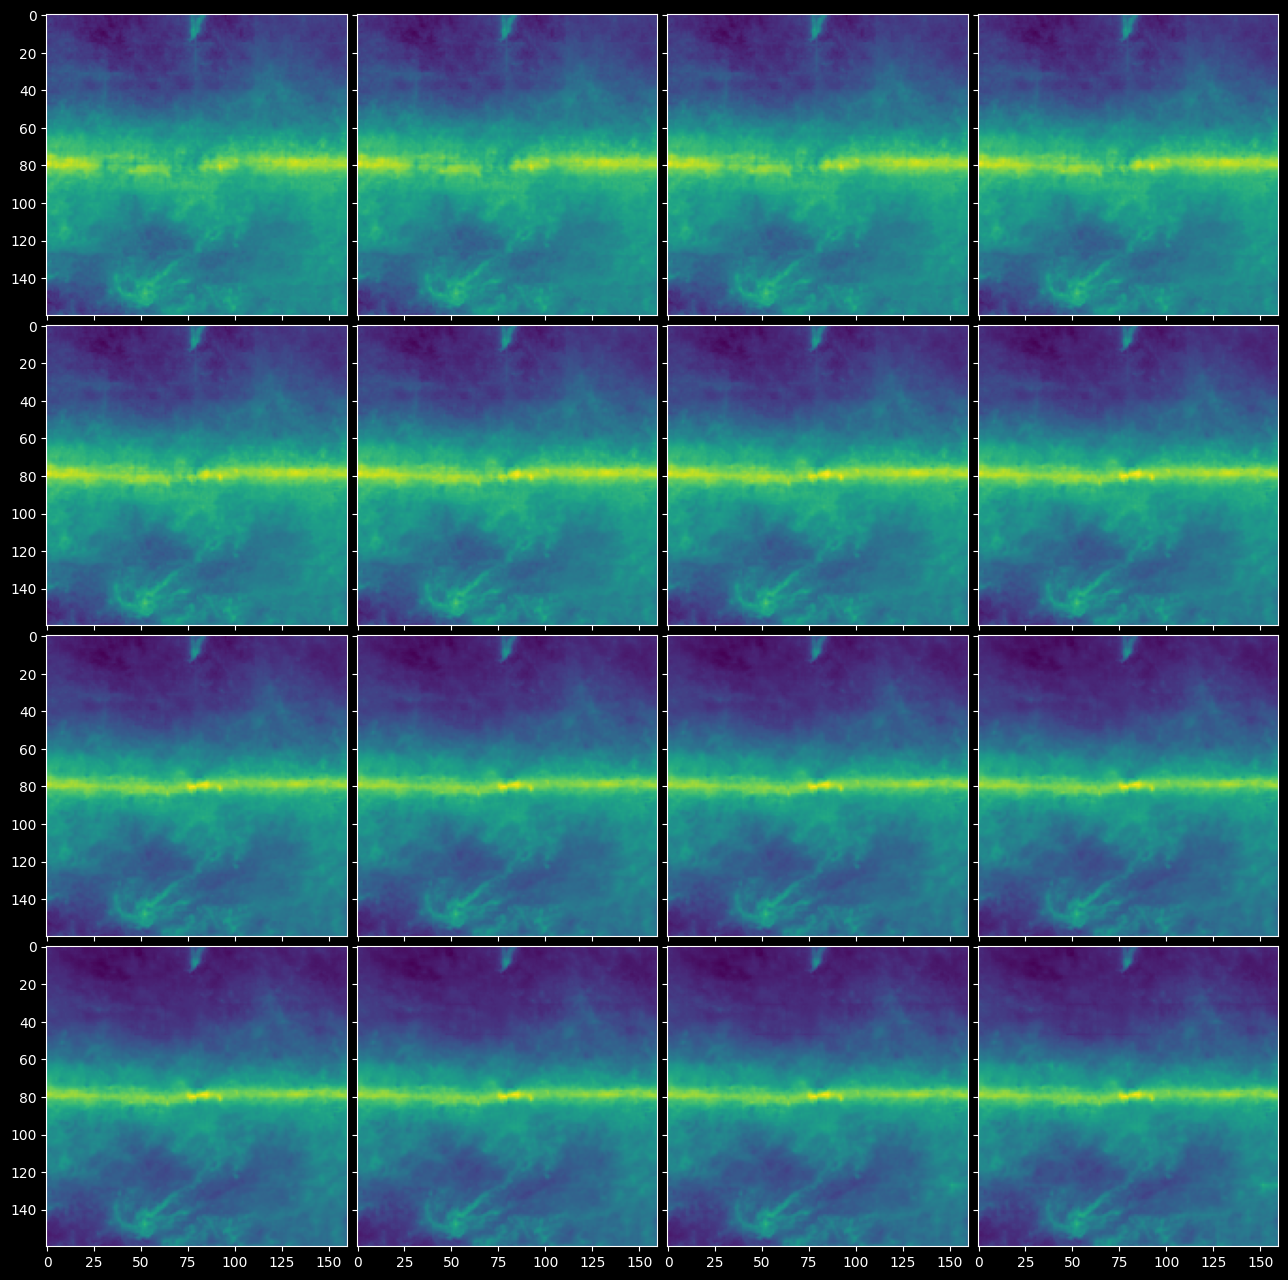

In [225]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),axes_pad=0.1,)

for ax, im in zip(grid, sample[:16, :, :, 0]):
    ax.imshow(im)

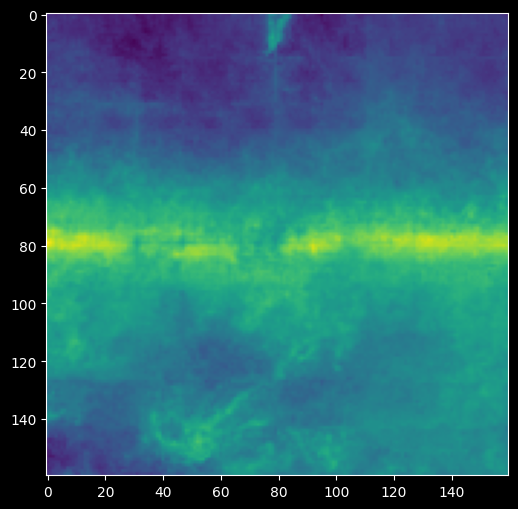

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from itertools import product, combinations

plt.style.use('dark_background')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6., 6.))

def update(frame):
    
    ax.clear()
    ax.imshow(sample[frame, :, :, 0])

update(0)

In [227]:
num_frames = 32

ani = FuncAnimation(fig, update, frames=np.arange(num_frames))
plt.tight_layout()

import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=10)
ani.save('pbc1.gif', dpi=150)

<Figure size 640x480 with 0 Axes>